In [2]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

In [3]:
date_columns = ['Date']
raw_data = pd.read_csv('../../data/avocado.csv', parse_dates=date_columns)
columns = ['Date', 'AveragePrice', 'type', 'year', 'region', 'Total Volume']
raw_data = raw_data[columns]

In [4]:
def feature_extractor(group_df):
    return pd.Series({
        'average_price': group_df['AveragePrice'].mean(),
        'total_volume': group_df['Total Volume'].sum()
    })

In [5]:
data_grouped = raw_data.copy()
columns = ['Date', 'AveragePrice', 'Total Volume']
data_grouped = data_grouped[columns]

data_grouped = data_grouped.groupby(['Date']).apply(feature_extractor).sort_values('Date').reset_index()
data_grouped = data_grouped.rename(columns={'Date':'date'})

In [6]:
data_grouped

,date,average_price,total_volume
0,2015-01-04,1.301296,8.467434e+07
1,2015-01-11,1.370648,7.855581e+07
2,2015-01-18,1.391111,7.838878e+07
3,2015-01-25,1.397130,7.646628e+07
4,2015-02-01,1.247037,1.194532e+08
...,...,...,...
164,2018-02-25,1.359630,1.092314e+08
165,2018-03-04,1.350185,1.118449e+08
166,2018-03-11,1.335093,1.114652e+08
167,2018-03-18,1.313704,1.136740e+08


<Axes: xlabel='date'>

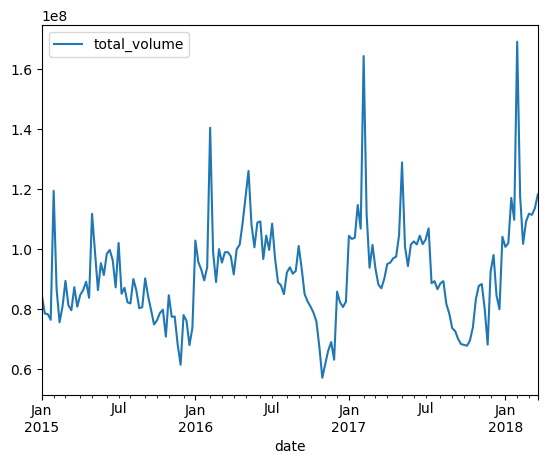

In [7]:
data_grouped.plot(x='date', y='total_volume')

In [17]:
import math
data = data_grouped.copy()
# Date features
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.isocalendar().week
# data['day_of_week'] = data['date'].dt.dayofweek
data['week_in_month'] = pd.to_numeric(data['date'].dt.day/7)
data['week_in_month'] = data['week_in_month'].apply(lambda x: math.ceil(x))
data['day'] = data['date'].dt.day
# data['hour'] = data['date'].dt.hour

# Determining if the day is a US federal holiday
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=data['date'].min() - pd.Timedelta(days=365), end=data['date'].max() + pd.Timedelta(days=365))
data['holiday'] = pd.to_datetime(data['date'].dt.strftime('%Y-%m-%d')).isin(holidays)


# Days since last holiday
data['days_since_last_holiday'] = pd.NaT
data.loc[data['holiday'], 'days_since_last_holiday'] = data.loc[data['holiday'], 'date'].values
data['days_since_last_holiday'] = data['days_since_last_holiday'].fillna(method='ffill').fillna(holidays[holidays <= data['date'].min()].max())
data['days_since_last_holiday'] = (data['date'] - data['days_since_last_holiday']).dt.total_seconds() / 3600 / 24

# Days to next holiday
data['days_until_next_holiday'] = pd.NaT
data.loc[data['holiday'], 'days_until_next_holiday'] = data.loc[data['holiday'], 'date'].values
data['days_until_next_holiday'] = data['days_until_next_holiday'].fillna(method='bfill').fillna(holidays[holidays >= data['date'].max()].min())
data['days_until_next_holiday'] = (data['days_until_next_holiday'] - data['date']).dt.total_seconds() / 3600 / 24

# Lagged features
base_columns = ['average_price', 'total_volume']
lags_in_days = [1, 2, 3, 4, 5, 6, 7]#, 14, 21, 28, 64, 84] #12 weeks, 3 months

dfs = {}

for column in base_columns:
    for lag in lags_in_days:
        dfs['{}_in_last_{}_weeks'.format(column, lag)] = data[column].rolling(window=lag + 1).mean()
        dfs['{}_{}_weeks_ago'.format(column, lag)] = data[column].shift(lag)

data = pd.concat([data, pd.DataFrame(dfs)], axis=1)
data = data.drop(columns=['holiday'])

In [19]:
data

,date,average_price,total_volume,month,week,week_in_month,day,days_since_last_holiday,days_until_next_holiday,average_price_in_last_1_weeks,...,total_volume_in_last_3_weeks,total_volume_3_weeks_ago,total_volume_in_last_4_weeks,total_volume_4_weeks_ago,total_volume_in_last_5_weeks,total_volume_5_weeks_ago,total_volume_in_last_6_weeks,total_volume_6_weeks_ago,total_volume_in_last_7_weeks,total_volume_7_weeks_ago
0,2015-01-04,1.301296,8.467434e+07,1,1,1,4,3.0,1240.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-11,1.370648,7.855581e+07,1,2,2,11,10.0,1233.0,1.335972,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-18,1.391111,7.838878e+07,1,3,3,18,17.0,1226.0,1.380880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-25,1.397130,7.646628e+07,1,4,4,25,24.0,1219.0,1.394120,...,7.952130e+07,8.467434e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-02-01,1.247037,1.194532e+08,2,5,1,1,31.0,1212.0,1.322083,...,8.821603e+07,7.855581e+07,8.750769e+07,8.467434e+07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,2018-02-25,1.359630,1.092314e+08,2,8,4,25,1151.0,92.0,1.366852,...,1.244445e+08,1.691778e+08,1.215147e+08,1.097951e+08,1.207767e+08,1.170872e+08,1.180983e+08,1.020277e+08,1.159357e+08,1.007971e+08
165,2018-03-04,1.350185,1.118449e+08,3,9,1,4,1158.0,85.0,1.354907,...,1.101113e+08,1.175776e+08,1.219246e+08,1.691778e+08,1.199030e+08,1.097951e+08,1.195008e+08,1.170872e+08,1.173166e+08,1.020277e+08
166,2018-03-11,1.335093,1.114652e+08,3,10,2,11,1165.0,78.0,1.342639,...,1.085832e+08,1.017913e+08,1.103821e+08,1.175776e+08,1.201814e+08,1.691778e+08,1.186976e+08,1.097951e+08,1.184963e+08,1.170872e+08
167,2018-03-18,1.313704,1.136740e+08,3,11,3,18,1172.0,71.0,1.324398,...,1.115539e+08,1.092314e+08,1.096014e+08,1.017913e+08,1.109307e+08,1.175776e+08,1.192518e+08,1.691778e+08,1.180697e+08,1.097951e+08


In [20]:
# Correct data for forecast horizon
forcast_horizon = 1

dataset = data.drop(columns=['average_price'])
dataset = dataset.rename(columns={'total_volume':'demand'})

dataset.insert(2, 'inference_time', dataset['date'])
dataset = dataset.iloc[max(lags_in_days)*1:,].reset_index(drop=True)

dataset[['date', 'demand']] = dataset[['date', 'demand']].shift(-forcast_horizon * 1)
dataset = dataset.loc[~dataset['date'].isnull()]

In [21]:
dataset

,date,demand,inference_time,month,week,week_in_month,day,days_since_last_holiday,days_until_next_holiday,average_price_in_last_1_weeks,...,total_volume_in_last_3_weeks,total_volume_3_weeks_ago,total_volume_in_last_4_weeks,total_volume_4_weeks_ago,total_volume_in_last_5_weeks,total_volume_5_weeks_ago,total_volume_in_last_6_weeks,total_volume_6_weeks_ago,total_volume_in_last_7_weeks,total_volume_7_weeks_ago
0,2015-03-01,8.943484e+07,2015-02-22,2,8,4,22,52.0,1191.0,1.375139,...,9.065940e+07,1.194532e+08,8.782078e+07,7.646628e+07,8.624878e+07,7.838878e+07,8.514978e+07,7.855581e+07,8.509035e+07,8.467434e+07
1,2015-03-08,8.128167e+07,2015-03-01,3,9,1,1,59.0,1184.0,1.336852,...,8.315480e+07,8.667111e+07,9.041449e+07,1.194532e+08,8.808979e+07,7.646628e+07,8.670393e+07,7.838878e+07,8.568541e+07,7.855581e+07
2,2015-03-15,7.967682e+07,2015-03-08,3,10,2,8,66.0,1177.0,1.335556,...,8.180744e+07,7.563716e+07,8.278018e+07,8.667111e+07,8.889235e+07,1.194532e+08,8.711720e+07,7.646628e+07,8.602615e+07,7.838878e+07
3,2015-03-22,8.734632e+07,2015-03-15,3,11,3,15,73.0,1170.0,1.376019,...,8.281736e+07,8.087609e+07,8.138132e+07,7.563716e+07,8.226295e+07,8.667111e+07,8.757585e+07,1.194532e+08,8.618715e+07,7.646628e+07
4,2015-03-29,8.084341e+07,2015-03-22,3,12,4,22,80.0,1163.0,1.370602,...,8.443491e+07,8.943484e+07,8.372315e+07,8.087609e+07,8.237549e+07,7.563716e+07,8.298915e+07,8.667111e+07,8.754716e+07,1.194532e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2018-02-25,1.092314e+08,2018-02-18,2,7,3,18,1144.0,99.0,1.340556,...,1.245855e+08,1.097951e+08,1.230858e+08,1.170872e+08,1.195761e+08,1.020277e+08,1.168934e+08,1.007971e+08,1.153008e+08,1.041529e+08
157,2018-03-04,1.118449e+08,2018-02-25,2,8,4,25,1151.0,92.0,1.366852,...,1.244445e+08,1.691778e+08,1.215147e+08,1.097951e+08,1.207767e+08,1.170872e+08,1.180983e+08,1.020277e+08,1.159357e+08,1.007971e+08
158,2018-03-11,1.114652e+08,2018-03-04,3,9,1,4,1158.0,85.0,1.354907,...,1.101113e+08,1.175776e+08,1.219246e+08,1.691778e+08,1.199030e+08,1.097951e+08,1.195008e+08,1.170872e+08,1.173166e+08,1.020277e+08
159,2018-03-18,1.136740e+08,2018-03-11,3,10,2,11,1165.0,78.0,1.342639,...,1.085832e+08,1.017913e+08,1.103821e+08,1.175776e+08,1.201814e+08,1.691778e+08,1.186976e+08,1.097951e+08,1.184963e+08,1.170872e+08


In [22]:
dataset.to_csv('../../data/avocados_demand_forecasting_dataset.csv', index=False)